In [1]:
import sys,os
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath('../modules/'))

import healpy as h
import multiprocessing as mp
from modules.settings import global_mmf_settings as gset
from data_preprocess import tiling_the_sphere as tts
from data_preprocess import tile_planck_data as tpd
from filters import modular_multi_matched_filter as mmf
from simulate import cluster_templates as cltemp

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# The catalogues were downloaded from analysis from on sirius5
# Downloaded from path : /scratch/nas_chluba/specdist/arotti/mmf_dataout/results/planck_pr3/planck_cat_hfi_inpainted_data/old_non_iterative_mmf/15deg_patches

In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_tiles/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=15.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
datapath=gset.mmfset.paths["result_data"]

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


<IPython.core.display.Javascript object>


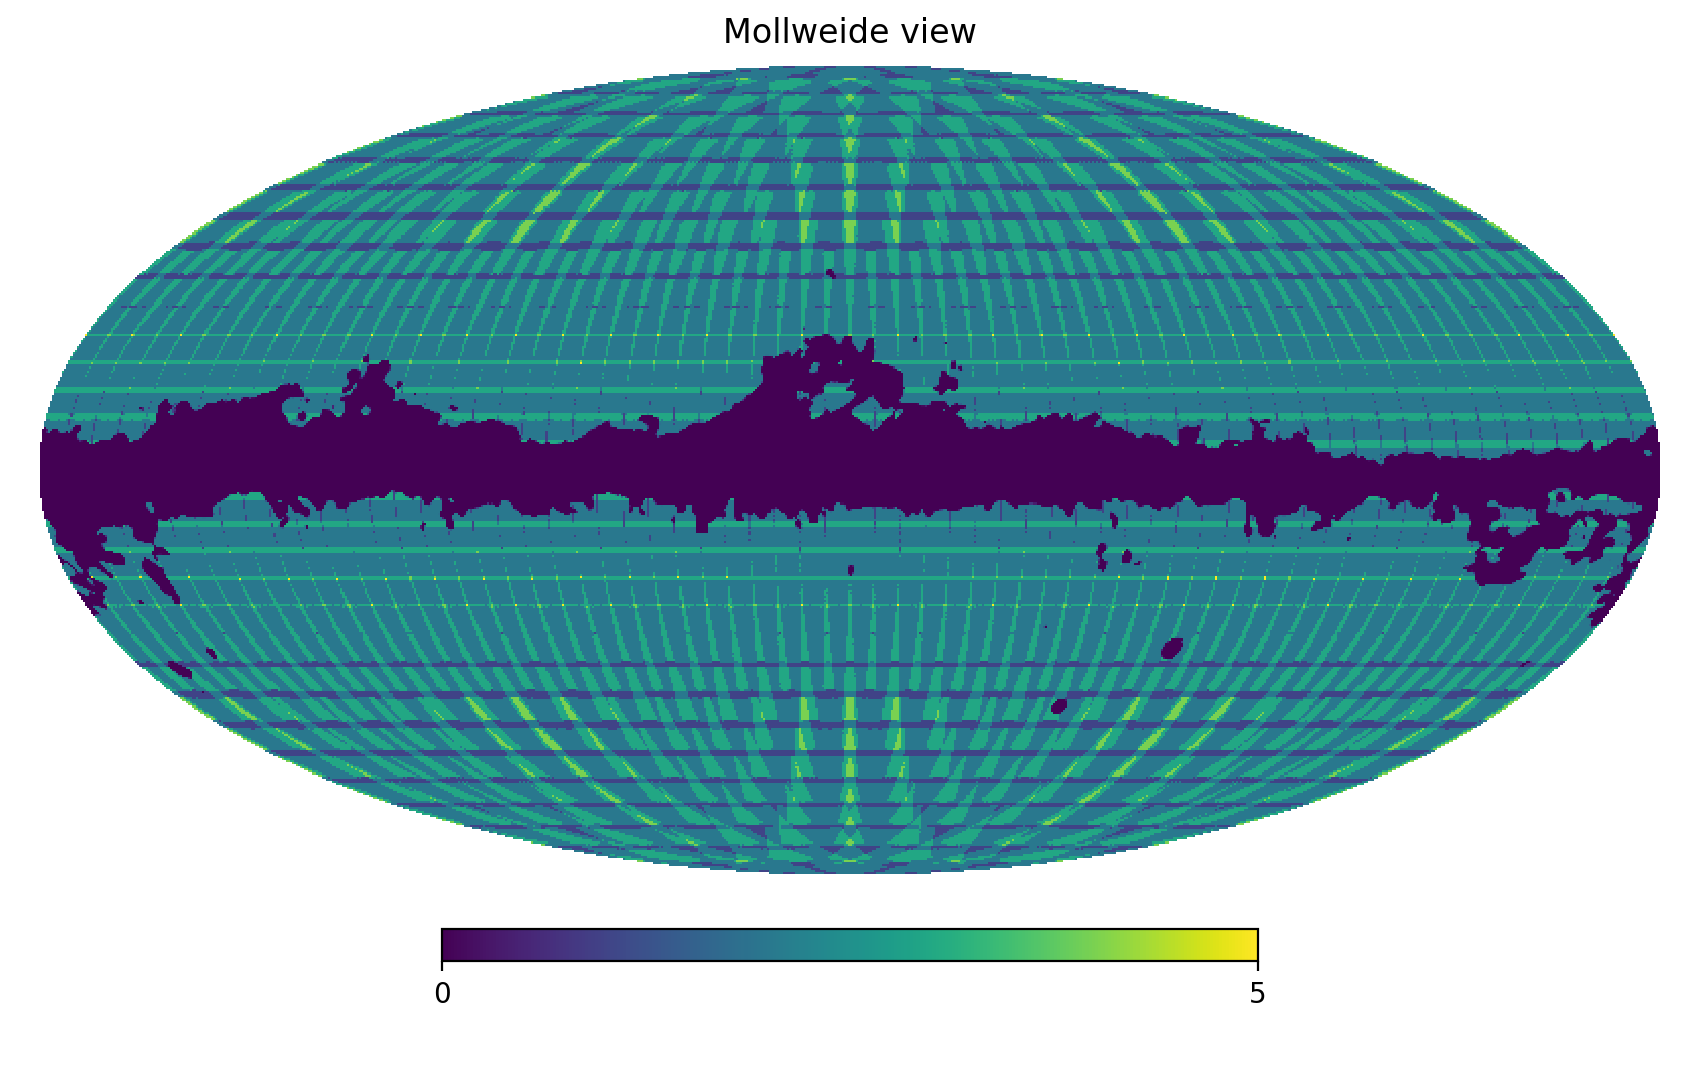

In [3]:
tile_map,fsky_map,apo_mask=tts.return_sky_tile_map()
tiledef=tpd.get_tangent_plane_fnames(fsky_map=fsky_map,fsky_thr=0.3)
h.mollview(tile_map)
filename=figpath + "tile_the_sky.pdf"
plt.savefig(filename,bbox_inches="tight",dpi=200)

In [4]:
for px in tiledef.keys():
    catname=gset.mmfset.result_path + "/data_old/" + tiledef[px]["TILENAME"] + ".dict"
    tiledef[px]['CATNAME']=catname

In [100]:
def myprint(text,verbose):
    if verbose:
        print text
        
def return_distance(gal_coord1,gal_coord2):
    glon1,glat1=gal_coord1
    glon2,glat2=gal_coord2
    theta1=(90.-glat1)*np.pi/180.
    theta2=(90.-glat2)*np.pi/180.
    phi1=glon1*np.pi/180.
    phi2=glon2*np.pi/180.
    cosbeta=np.sin(theta1)*np.sin(theta2)*np.cos(phi2-phi1)+np.cos(theta1)*np.cos(theta2)
    cosbeta=np.sign(cosbeta)*min(np.abs(cosbeta),1.)
    beta=np.arccos(cosbeta)*180.*60./np.pi
    return beta

vec_return_distance=np.vectorize(return_distance)
        
def return_final_cluster_catalogue(tiledef,verbose=False):
    tile_cluscat={}
#     for px in tiledef.keys():
#         if os.path.isfile(tiledef[px]["CATNAME"]):
#             temp_cat=etcc.read_dict(tiledef[px]["CATNAME"])
#             tile_cluscat[tiledef[px]["TILENAME"]]=temp_cat["cat"]
            
    all_files=os.listdir(gset.mmfset.result_path + "/data_old/")
    for tname in all_files:
        fname=gset.mmfset.result_path + "/data_old/" + tname
        temp_cat=etcc.read_dict(fname)
        px=temp_cat["pix"]
        tile_cluscat[tiledef[px]["TILENAME"]]=temp_cat["cat"]

    final_cat={}
    for tile in tile_cluscat.keys():
        for ict in tile_cluscat[tile].keys():
            nc=[]
            for jct in final_cat.keys():
                dist=return_distance(tile_cluscat[tile][ict]["mp_gal_coord"],final_cat[jct]["mp_gal_coord"])
                nc=nc + [dist<tile_cluscat[tile][ict]["mp_thetac"] or dist<final_cat[jct]["mp_thetac"]]

            if any(nc):
                myprint("This cluster exists in the catalogue",verbose)
                match_ict=np.where(nc)[0][0]
                if tile_cluscat[tile][ict]["mp_snr"]>final_cat[match_ict]["mp_snr"]:
                    myprint("Updating the cluster definition",verbose)
                    final_cat[match_ict]=tile_cluscat[tile][ict]
            else:
                myprint("New cluster detected, adding to the cluster catalogue",verbose)
                match_ict=len(final_cat.keys())
                final_cat[match_ict]=tile_cluscat[tile][ict]
    cat_summary={}
    cat_summary["Total clusters"]=len(final_cat.keys())
    cat_summary["Catalogue"]=final_cat
    catname=gset.mmfset.paths["result_data"] + "full_sky_catalogue.dict"
#     write_dict(catname,cat_summary)
    return cat_summary

In [104]:
cat_summary=return_final_cluster_catalogue(tiledef)

In [59]:
from automated_detection import extract_tile_cluster_catalogue_v1 as etcc

In [30]:
for px in tiledef.keys():
    catname=gset.mmfset.result_path + "/data_old/" + tiledef[px]["TILENAME"] + ".dict"
    tiledef[px]['CATNAME']=catname

In [41]:
all_files=os.listdir(gset.mmfset.result_path + "/data_old/")

In [105]:
tile_cluscat={}
mmf_err=np.zeros((h.nside2npix(8),len(temp_cat["theta500"])))
tile_fsky=np.zeros(h.nside2npix(8))
missing_px=[]

all_files=os.listdir(gset.mmfset.result_path + "/data_old/")
for tname in all_files:
    fname=gset.mmfset.result_path + "/data_old/" + tname
    temp_cat=etcc.read_dict(fname)
    px=temp_cat["pix"]
    tile_cluscat[tiledef[px]["TILENAME"]]=temp_cat["cat"]
    tile_fsky[px]=temp_cat["fsky"]
    for ith,th in enumerate(temp_cat["theta500"]):
        mmf_err[px,ith]=temp_cat["err_Y500"][ith]

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


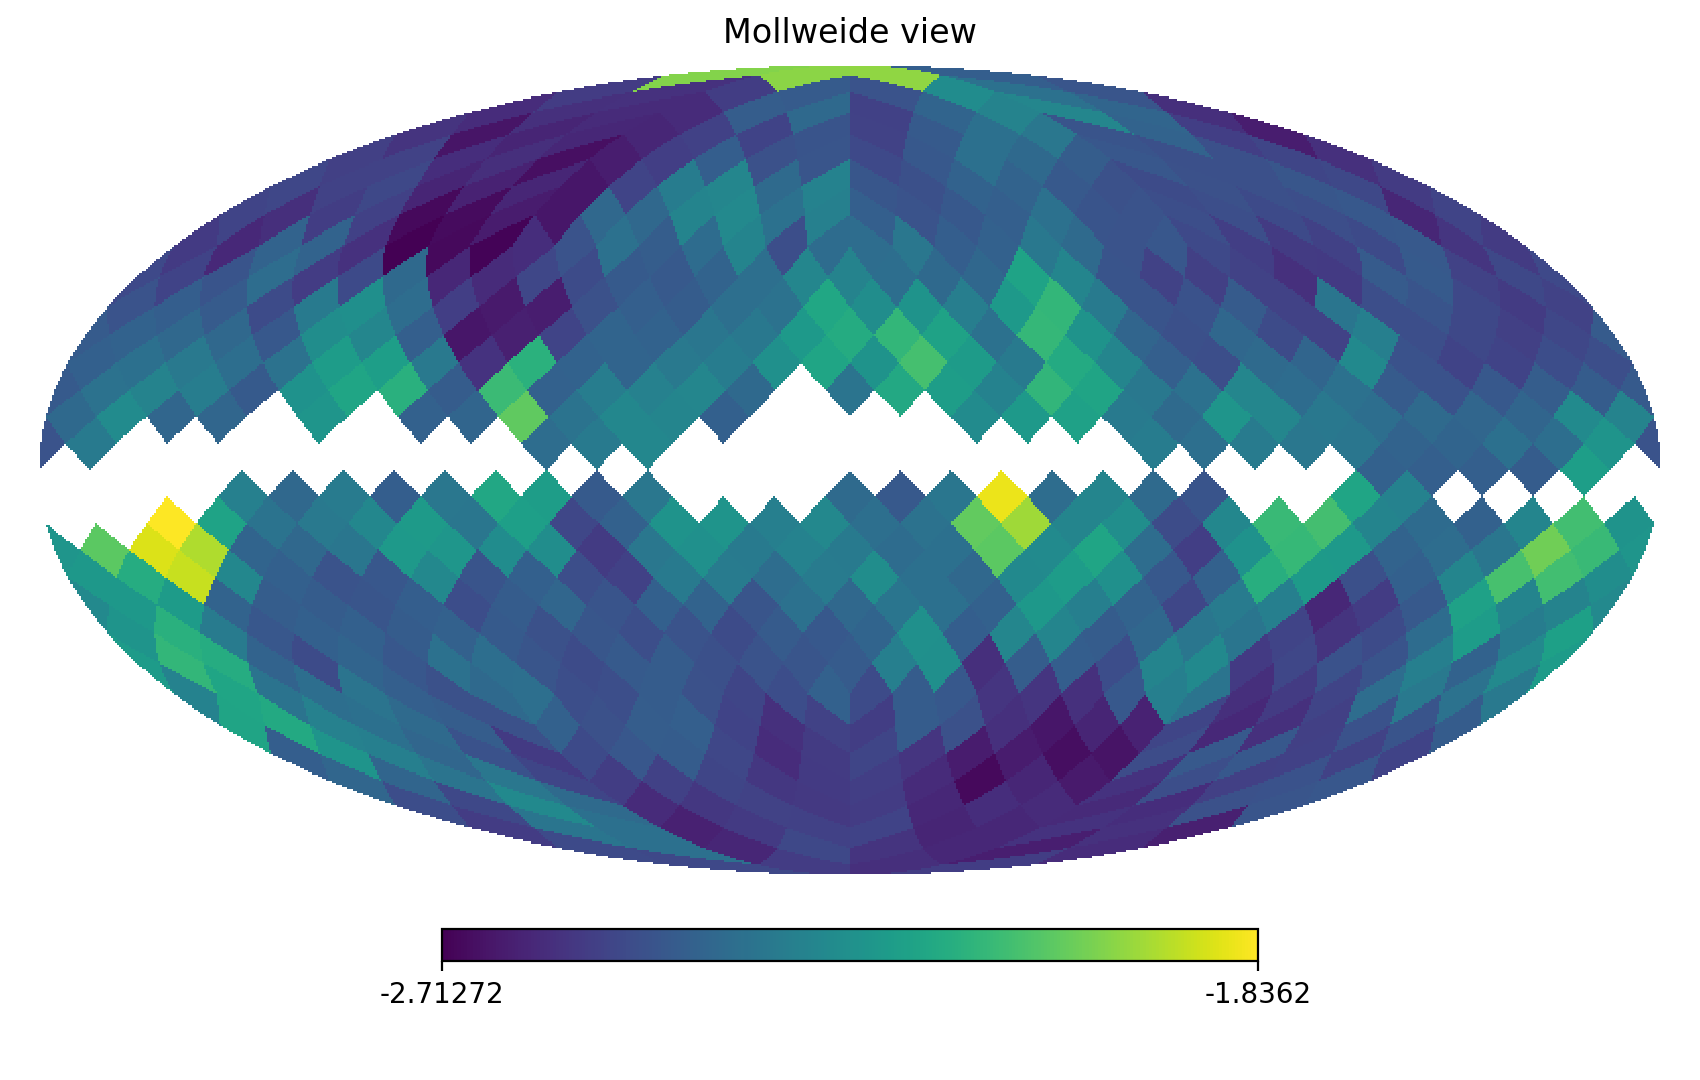

In [106]:
h.mollview(log10(mmf_err[:,0]),rot=(0,0))

In [198]:
snr=np.array([])
thc=np.array([])
nsc=np.array([])
nside=128
ncmap=np.zeros(h.nside2npix(nside))
thr_cat={}
cnt=0
for idx in cat_summary["Catalogue"].keys():
    mysnr=cat_summary["Catalogue"][idx]["mp_snr"]
    theta500=cat_summary["Catalogue"][idx]["mp_thetac"]
    num_scl=len(cat_summary["Catalogue"][idx]["snr"])
    if mysnr>5 and num_scl>5.:
        px=h.ang2pix(nside,*cat_summary["Catalogue"][idx]["mp_gal_coord"],lonlat=True)
        ncmap[px]=ncmap[px]+1
        thr_cat[cnt]=cat_summary["Catalogue"][idx]
        cnt=cnt+1
        snr=np.append(snr,mysnr)
        thc=np.append(thc,theta500)
        nsc=np.append(nsc,num_scl)

In [199]:
len(snr)

1763

<IPython.core.display.Javascript object>


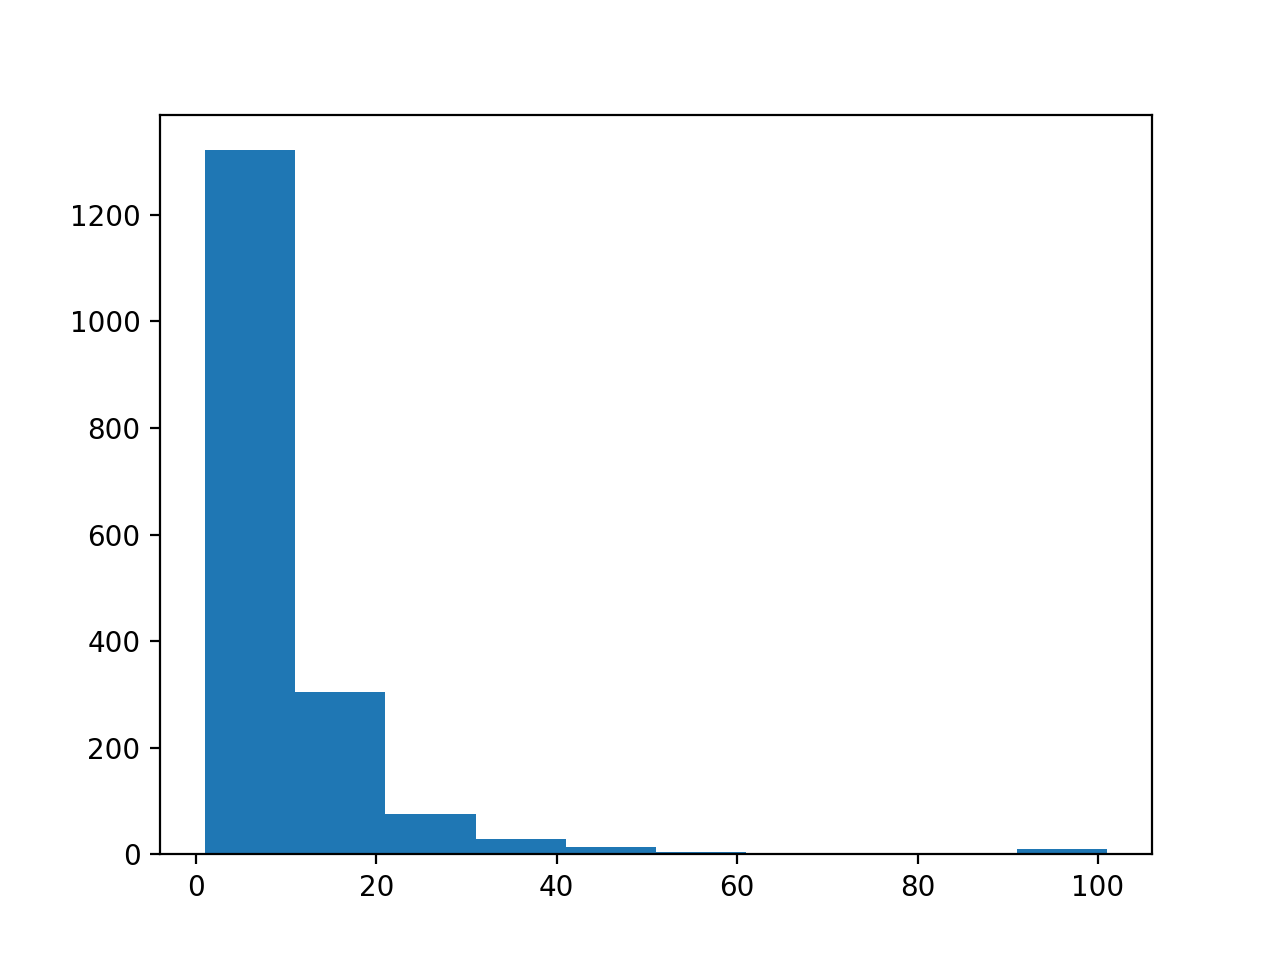

(array([1.321e+03, 3.050e+02, 7.500e+01, 2.800e+01, 1.400e+01, 4.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 1.100e+01]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.]),
 <a list of 10 Patch objects>)

In [200]:
figure()
hist(thc)

In [147]:
mask=h.read_map(gset.mmfset.gal_mask_name,1)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


IndexError: list index out of range

<IPython.core.display.Javascript object>


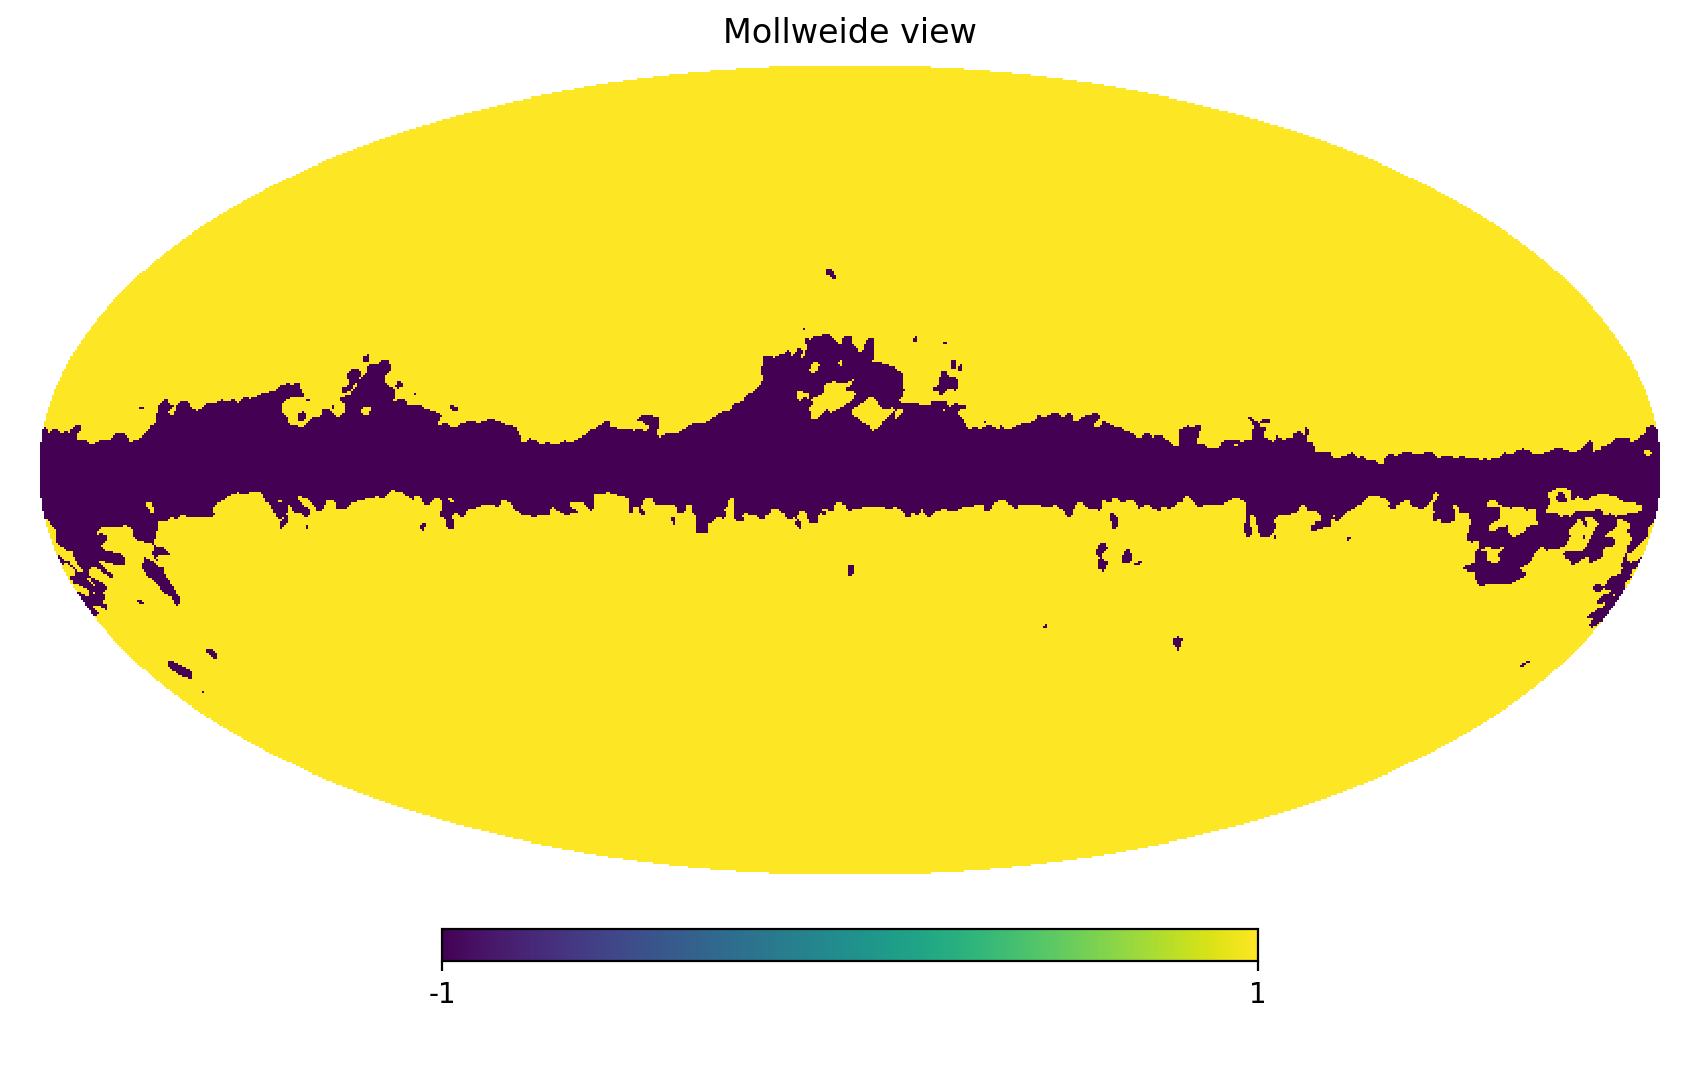

In [148]:
h.mollview(1-mask)

In [149]:
sum(1-mask)/size(mask)

0.6999999682108561

In [157]:
mask=h.read_map("/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits")

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [161]:
mask=h.ud_grade(mask,128)
mask[mask<0.7]=0
mask[mask>=0.7]=1

<IPython.core.display.Javascript object>


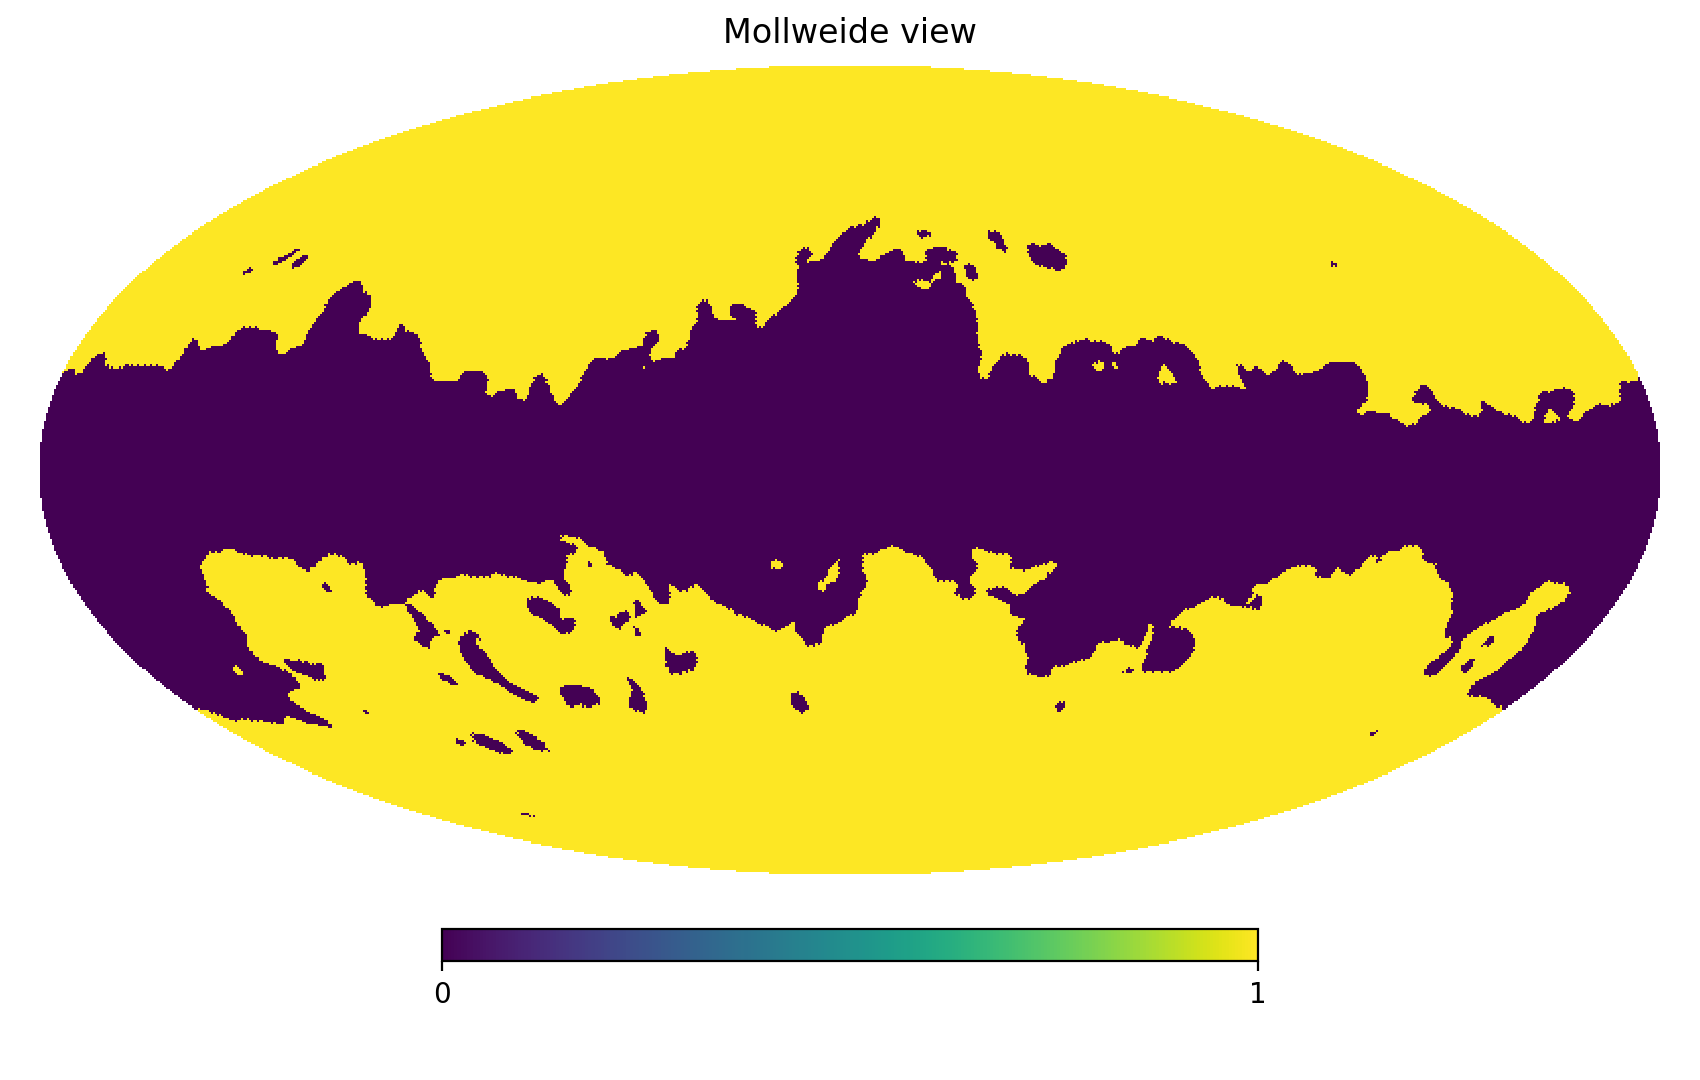

In [162]:
h.mollview(mask)

In [124]:
h.ang2pix(8,*cat_summary["Catalogue"][idx]["mp_gal_coord"],lonlat=True)

76

In [127]:
vec=h.ang2vec(*cat_summary["Catalogue"][idx]["mp_gal_coord"],lonlat=True)
h.vec2pix(8,*vec)

76

# Number of clusters detected per tile